# PLAsTiCC SNIa

In [1]:
import numpy as np

from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.astro_utils.pzflow_node import PZFlowNode
from lightcurvelynx.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
)
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.sncosmo_models import SncosmoWrapperModel
from lightcurvelynx.models.snia_host import SNIaHost
from lightcurvelynx.utils.plotting import plot_lightcurves

## Load Data Files

We start by loading the files we will need for running the simulation: the OpSim database and the passband information. Both of these live in the `data/` directory in the root directory. Note that nothing in this directory is saved to github, so the files might have to be downloaded initially.

For Rubin, a large number of OpSims can be found at [https://s3df.slac.stanford.edu/data/rubin/sim-data/](https://s3df.slac.stanford.edu/data/rubin/sim-data/). You can download an OpSim manually or using the `from_url()` helper function:

> opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"
> opsim_data = OpSim.from_url(opsim_url)

In [2]:
# Load the OpSim data.
opsim_db = OpSim.from_db(_LIGHTCURVELYNX_BASE_DATA_DIR / "opsim" / "baseline_v5.0.1_10yrs.db")

t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")

# Load the passband data for the griz filters only.
# Use a (possibly older) cached version of the passbands to avoid downloading them.
passband_group = PassbandGroup.from_preset(preset="LSST")
print(f"Loaded Passbands: {passband_group}")

Loaded OpSim with 2092088 rows and times [60981.00225242024, 64632.27310353035]
Loaded Passbands: PassbandGroup containing 6 passbands: LSST_u, LSST_g, LSST_r, LSST_i, LSST_z, LSST_y


## Create the model

To generate simulationed lightcurves we need to define the proporties of the object from which to sample. We start by creating a host based on a pre-trained pzflow model.

In [3]:
# Load the Flow model into a PZFlow node. This gives access to all of the outputs of the
# flow model as attributes of the PZFlowNode.
pz_node = PZFlowNode.from_file(
    _LIGHTCURVELYNX_BASE_DATA_DIR / "model_files" / "snia_hosts_test_pzflow.pkl",  # filename
    node_label="pznode",
)

# Create a model for the host of the SNIa. The attributes will be sampled via
# the PZFlowNode's model. So each host instantiation will have its own properties.
# Note: This requires the user to know the output names from the underlying flow model.
host = SNIaHost(
    ra=pz_node.RA_GAL,
    dec=pz_node.DEC_GAL,
    hostmass=pz_node.LOGMASS,
    redshift=NumpyRandomFunc("uniform", low=0.1, high=0.6),
    node_label="host",
)

Next we create the SNIa model itself. We use sncosmo's SALT2 model with parameters randomly generated from toy distributions.

Note that some attributes, such as (RA, dec), are sampled relative to the host's properties.

In [4]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
x1_func = HostmassX1Func(host.hostmass)
c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19.3, scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=x1_func,
    c=c_func,
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt2-h17"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x1_func,
    c=c_func,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.01),
    redshift=host.redshift,
    node_label="source",
)

## Generate the simulations

We can now generate random simulations with all the information defined above. The light curves are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. 

In [5]:
lightcurves = simulate_lightcurves(source, 1_000, opsim_db, passband_group)
lightcurves

Simulating:   0%|                                     | 0/1000 [00:00<?, ?obj/s]/Users/mi/Work/lightcurvelynx/lightcurvelynx/src/lightcurvelynx/models/physical_model.py:483: UserWarning: Some times are less than the model's defined bounds and no time extrapolation is set. If this is not the intended, you can enable time extrapolation using the 'time_extrapolation' parameter.
  warnings.warn(
/Users/mi/Work/lightcurvelynx/lightcurvelynx/src/lightcurvelynx/models/physical_model.py:507: UserWarning: Some times are greater than the model's defined bounds and no time extrapolation is set. If this is not the intended, you can enable time extrapolation using the 'time_extrapolation' parameter.
  warnings.warn(
Simulating: 100%|█████████████████████████| 1000/1000 [00:03<00:00, 301.82obj/s]


id         ra        dec  nobs            t0         z  \
0      0  55.203675 -43.339194   793  63570.597854  0.515890   
1      1  55.221735 -43.174063   790  63419.392677  0.371712   
..   ...        ...        ...   ...           ...       ...   
998  998  55.156251 -43.256093   788  61798.302971  0.163634   
999  999  55.209371 -43.266184   790  61446.392155  0.258065   

                                                params  \
0    {'pznode.RA_GAL': 55.204357, 'pznode.DEC_GAL':...   
1    {'pznode.RA_GAL': 55.20966, 'pznode.DEC_GAL': ...   
..                                                 ...   
998  {'pznode.RA_GAL': 55.176205, 'pznode.DEC_GAL':...   
999  {'pznode.RA_GAL': 55.21427, 'pznode.DEC_GAL': ...   

                                            lightcurve  
0    [{mjd: 60997.046651, filter: 'g', flux: -95.86...  
1    [{mjd: 60997.046651, filter: 'g', flux: -117.9...  
..                                                 ...  
998  [{mjd: 60997.046651, filter: 'g', flux: 60.900...  
999  [{mjd: 60997.046651, filter: 'g', flux: 21.502...  

[1000 rows x 8 columns]

Now let's plot some random light curves

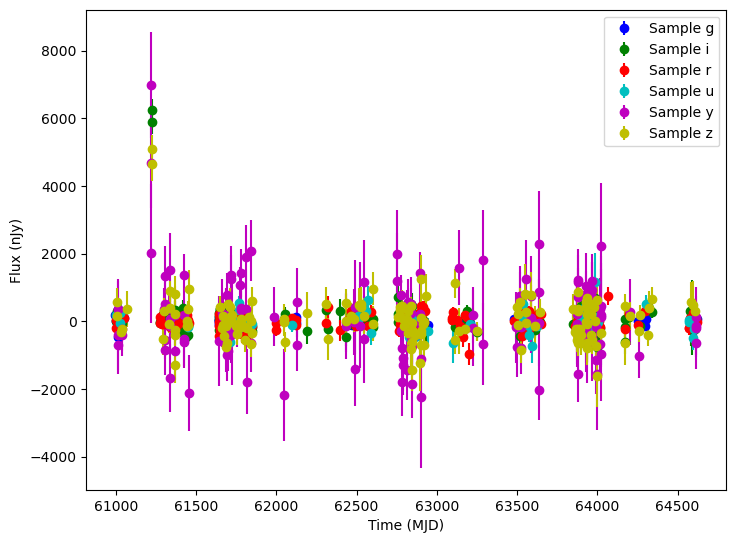

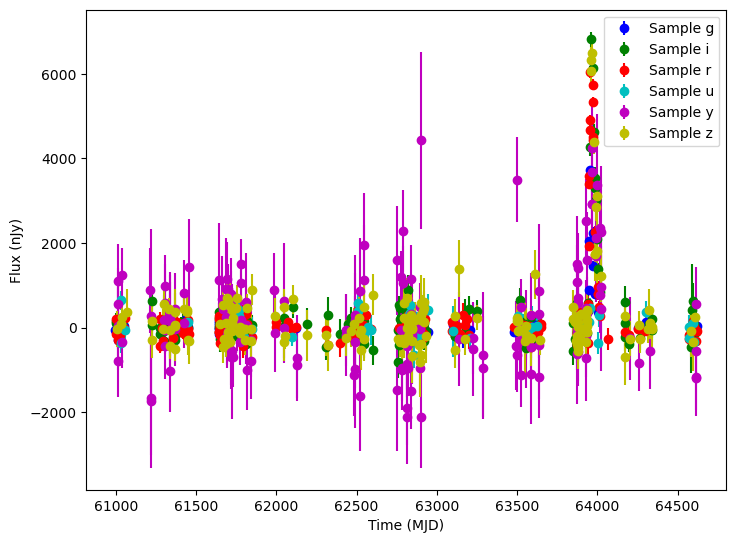

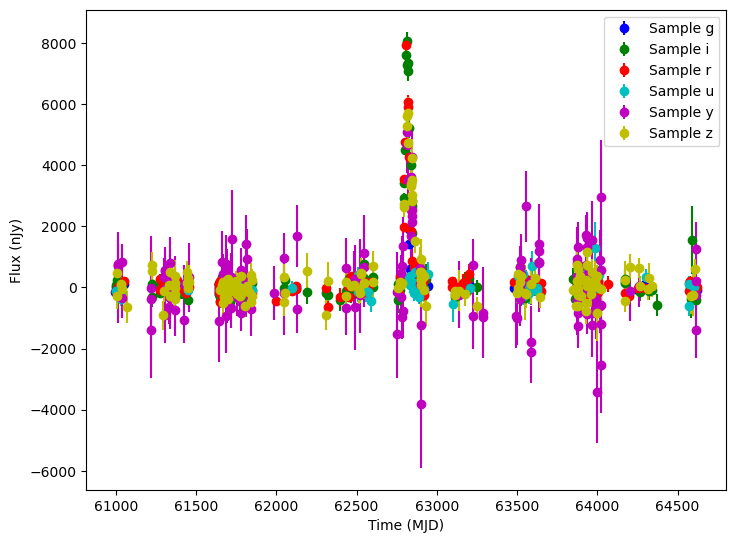

In [6]:
lightcurves = lightcurves.dropna(subset=['lightcurve'])
random_ids = np.random.choice(len(lightcurves), 3)

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.iloc[random_id]

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
    )

Let's apply some detection threshold and plot only detections.

/Users/mi/anaconda3/envs/lightcurvelynx/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:1349: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


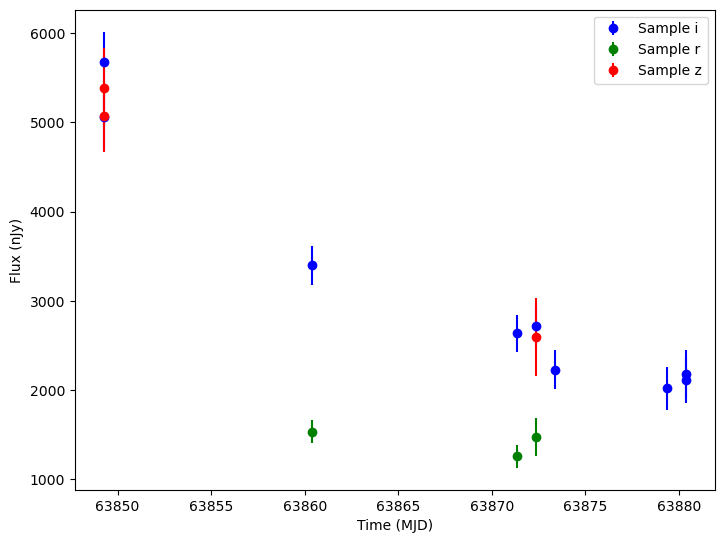

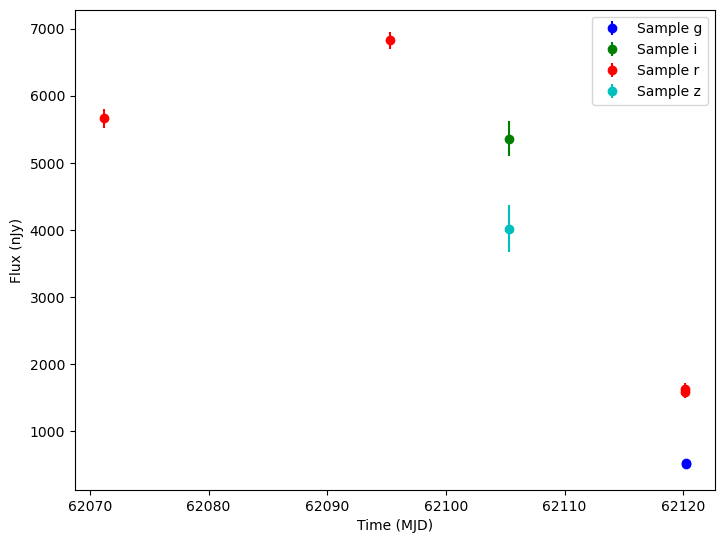

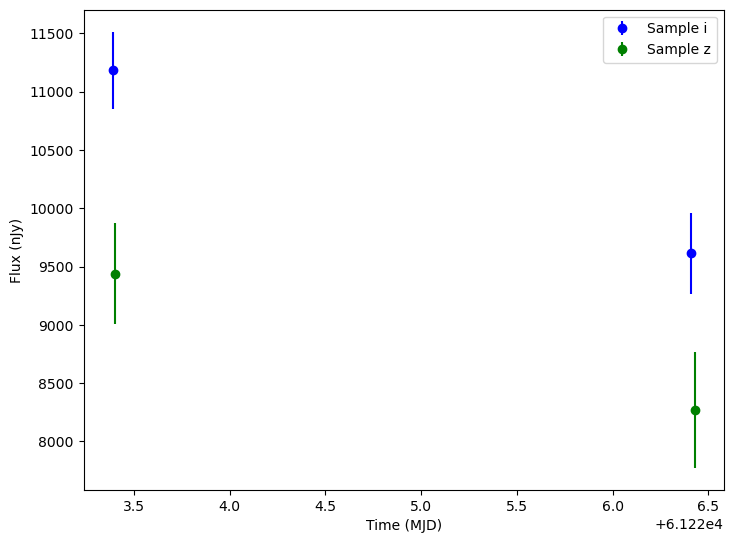

In [7]:
lightcurves['lightcurve.snr'] = lightcurves['lightcurve.flux']/lightcurves['lightcurve.fluxerr']
detections = lightcurves.query('lightcurve.snr > 5').dropna(subset=['lightcurve'])
random_ids = np.random.choice(len(detections), 3)

for random_id in random_ids:
    # Extract the row for this object.
    lc = detections.iloc[random_id]

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
    )